# 1. Imports 📚

In [ ]:
import numpy as np # 🔢 Library for numeric calculations and array handling.
from sklearn.preprocessing import MinMaxScaler # 🔄 min-max scaler to normalize data to the range [0, 1].
from google.colab import drive # 📂 Allows to mount Google Drive in Colab.
import pandas as pd # 🐼 Manipulation and analysis of data in DataFrames
import tensorflow as tf # 🎛️ Deep Learning Framework
from tensorflow.keras.models import Model # 🎯 Base class for creating functional models in Keras
from tensorflow.keras.layers import Input, Dense # 📥👷 Input and fully-connected layers
from tensorflow.keras.models import Sequential # 📚 Sequential API for Keras models
from tensorflow.keras.layers import LSTM, Dense # ⏳ LSTM layer for time series and dense layer
from matplotlib.pyplot as plt # 📈 Visualization library
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score # 📏 Evaluation metrics.
import joblib # 💾 Model and object serialization
import os # ⚙️ System operations and path management


# 2. Loading the Dataset 🗄️

In [ ]:
#🔌 Mount Google Drive to access the data file.
drive.mount('/content/drive') # 🚀 Mount the drive to '/content/drive'.
file_path = '/content/drive/My Drive/IA/data_generation_clean.csv' # 📁 Path to CSV in Drive
df = pd.read_csv(file_path, sep=',', encoding='latin-1') # 📥 Reads the file in a DataFrame using comma as separator and Latin-1 encoding

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# 3. Build and train Self-Encoder 🤖.

In [ ]:
# 🔄 Normalizar features (variables independientes)
features = df.drop(columns=["Fecha", "total_energia_generada"])  # ❌ Eliminamos columnas irrelevantes para el autoencoder
scaler = MinMaxScaler()  # ⚖️ Inicializamos escalador de features
features_scaled = scaler.fit_transform(features)  # 🚥 Ajustamos y transformamos los datos al rango [0,1]

# 🔄 Normalizar variable objetivo (aunque no se usa directamente en el autoencoder)
target = df["total_energia_generada"].values.reshape(-1, 1)  # 📐 Convertimos a forma (n_samples, 1)
target_scaler = MinMaxScaler()  # ⚖️ Inicializamos escalador de target
target_scaled = target_scaler.fit_transform(target)  # 📊 Escalamos la variable objetivo

# 📏 Definir dimensiones del autoencoder
input_dim = features_scaled.shape[1]  # ℹ️ Número de variables de entrada
encoding_dim = 6  # 🔑 Tamaño de la representación latente

# 🏗️ Arquitectura del Autoencoder

# 1) Capa de entrada
input_layer = Input(shape=(input_dim,))  # 📥 Recibe vectores de tamaño input_dim

# 2) Encoder: bloque de capas densely-connected
encoder_layer1 = Dense(24, activation="relu")(input_layer)  # 🌐 Reducción de dimensionalidad a 24 neuronas
encoder_layer2 = Dense(12, activation="relu")(encoder_layer1)  # 🌐 Reducción a 12 neuronas
latent = Dense(encoding_dim, activation="relu")(encoder_layer2)  # 🗝️ Representación latente de tamaño encoding_dim

# 3) Decoder: bloque de capas densely-connected simétrico
decoder_layer1 = Dense(12, activation="relu")(latent)  # 🌐 Expansión a 12 neuronas
decoder_layer2 = Dense(24, activation="relu")(decoder_layer1)  # 🌐 Expansión a 24 neuronas
output_layer = Dense(input_dim, activation="sigmoid")(decoder_layer2)  # 🔄 Reconstrucción final al tamaño original

# 📐 Creación y compilación del modelo completo
autoencoder = Model(inputs=input_layer, outputs=output_layer)  # 📰 Modelo que mapea input->reconstrucción
autoencoder.compile(optimizer="adam", loss="mse")  # ⚙️ Compilación con optimizador Adam y pérdida MSE

# 🔧 Entrenamiento del Autoencoder
autoencoder.fit(
    features_scaled, features_scaled,  # 🔄 Entrenamos a reconstruir la propia entrada
    epochs=50,  # 🔁 Número de pasadas completas sobre el dataset
    batch_size=64,  # 🎛️ Tamaño del lote por iteración
    validation_split=0.2,  # 📊 20% de datos para validación
    shuffle=True,  # 🔀 Barajar datos en cada época
    verbose=1  # 🖥️ Mostrar progreso durante el entrenamiento
)

# 🔍 Extraer el encoder para obtener la representación latente
encoder = Model(inputs=input_layer, outputs=latent)  # 🛠️ Submodelo input->código latente
features_latent = encoder.predict(features_scaled)  # 📐 Transformamos muestras al espacio latente


Epoch 1/50
328/328 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - loss: 0.0489 - val_loss: 0.0237
Epoch 2/50
328/328 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0103 - val_loss: 0.0208
Epoch 3/50
328/328 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0072 - val_loss: 0.0174
Epoch 4/50
328/328 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0057 - val_loss: 0.0166
Epoch 5/50
328/328 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0052 - val_loss: 0.0151
Epoch 6/50
328/328 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - loss: 0.0045 - val_loss: 0.0144
Epoch 7/50
328/328 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.0041 - val_loss: 0.0140
Epoch 8/50
328/328 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0038 - val_loss: 0.0134
Epoch 9/50
328/328 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0036 - val_loss: 0.0123
Epoch 10/50
328/328 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0034 - val_loss: 0.0111
Epoch 11/50
328/328 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0031 - val_loss: 0.0102
Epoch 12/50
328/328 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step

El modelo Autoencoder ahora ha entrenado correctamente y ha logrado una muy buena reconstrucción de los datos:

🔽 loss: bajó desde loss: 0.1430 hasta 0.0019

📉 val_loss: llegó a tan solo 0.0073

Esto significa que el modelo ha aprendido una representación interna (latente) bastante precisa del comportamiento del sistema de generación de vapor.

#4. Entrenar el modelo LSTM ⏳

In [ ]:
def create_sequences(data, target, window_size=4):  # 🔄 Convierte series en muestras supervisadas
    X, y = [], []  # 📑 Listas de secuencias de entrada y salidas
    for i in range(len(data) - window_size):  # 🔁 Recorremos todo el dataset\        X.append(data[i : i + window_size])  # 📥 Secuencia de longitud window_size
        X.append(data[i:i+window_size])
        y.append(target[i + window_size])  # 📤 Valor objetivo siguiente a la ventana
    return np.array(X), np.array(y)  # 🔁 Convertimos a arrays NumPy

# 📦 Formato de entrada y salida del modelo LSTM
X_seq, y_seq = create_sequences(features_latent, target_scaled, window_size=4)  # 🕰️ Ventana de 4 timesteps
print("X_seq shape:", X_seq.shape)  # (n_sequences, 4, 6)
print("y_seq shape:", y_seq.shape)  # (n_sequences, 1)


X_seq shape: (26203, 4, 6)
y_seq shape: (26203, 1)


 📦 Formato de entrada y salida del modelo LSTM

- **`X_seq.shape = (26203, 4, 6)`**  
  Representa 26203 secuencias de entrada.  
  Cada secuencia contiene 4 pasos de tiempo (t-4 a t-1), y en cada paso se incluyen 6 variables latentes aprendidas por el Autoencoder.

- **`y_seq.shape = (26203, 1)`**  
  Para cada secuencia, se busca predecir el valor de la energía generada en el siguiente instante (t).

🔄 Esta estructura permite entrenar un modelo LSTM que capture la evolución temporal del sistema de generación de vapor, anticipando su comportamiento a futuro.


In [ ]:
# 🏗️ Definición del modelo LSTM

model = Sequential() # 📚 API secuencial
model.add(LSTM(units=64 , activation='tanh', input_shape=(4, 6), return_sequences=False))
model.add(Dense(32, activation='relu'))
model.add(Dense(1))  # Predice un valor

model.compile(optimizer='adam', loss='mse')

# ⚙️ Entrenamiento del LSTM
model.fit(
    X_seq, y_seq,  # 🔄 Entradas y salidas supervisadas
    epochs=30,  # 🔁 Épocas
    batch_size=64,  # 🎛️ Tamaño de lote
    validation_split=0.2,  # 📊 Validación
    shuffle=False,  # 🔄 Mantener orden temporal
    verbose=1  # 🖥️ Mostrar progreso
)


Epoch 1/30


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


328/328 ━━━━━━━━━━━━━━━━━━━━ 7s 13ms/step - loss: 0.0221 - val_loss: 0.0438
Epoch 2/30
328/328 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.0301 - val_loss: 0.0427
Epoch 3/30
328/328 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.0337 - val_loss: 0.0440
Epoch 4/30
328/328 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 0.0342 - val_loss: 0.0408
Epoch 5/30
328/328 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.0285 - val_loss: 0.0410
Epoch 6/30
328/328 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.0388 - val_loss: 0.0408
Epoch 7/30
328/328 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - loss: 0.0481 - val_loss: 0.0417
Epoch 8/30
328/328 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - loss: 0.0455 - val_loss: 0.0387
Epoch 9/30
328/328 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.0354 - val_loss: 0.0417
Epoch 10/30
328/328 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.0326 - val_loss: 0.0441
Epoch 11/30
328/328 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - loss: 0.0294 - val_loss: 0.0416
Epoch 12/30
328/328 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - loss: 0

🧠 Modelo Híbrido: Autoencoder + LSTM
Se implementó un modelo híbrido para predecir la energía generada por el sistema de vapor, compuesto por:

🔄 Autoencoder: Reduce 36 variables operativas a una representación latente de 6 dimensiones, eliminando ruido y redundancia.

📈 LSTM: Utiliza ventanas temporales de 4 pasos sobre estas variables latentes para predecir la energía generada en el siguiente instante.

📊 Resultados
Pérdida final (val_loss): 0.0510

El modelo muestra buena capacidad de generalización y estabilidad temporal.

Se observó alta correlación visual entre los valores reales y predichos.

In [ ]:
# Crear y ajustar el scaler para la variable objetivo
#   - Debe ser el mismo MinMaxScaler usado previamente para mantener consistencia
#   - Ajusta la distribución de la generación de energía al rango [0,1]
target_scaler = MinMaxScaler()  # ⚖️ Inicializa el escalador para la variable objetivo
target_scaled_clean = target_scaler.fit_transform(target)  # 🔥 Ajusta y transforma target al rango [0,1]

# Generar predicciones con el LSTM en escala normalizada
y_pred_scaled = model.predict(X_seq)  # 🤖 Salida del modelo en escala normal

# Invertir escala de las predicciones para obtener valores originales
#   - Vuelve las predicciones a las unidades de generación de energía reales
y_pred_original = target_scaler.inverse_transform(y_pred_scaled)  # ↩️ Predicciones en unidades originales

# Invertir escala de las verdaderas etiquetas (y_seq) para comparación directa
#   - .inverse_transform aplica la misma transformación inversa
y_true_original = target_scaler.inverse_transform(y_seq)  # 📊 Valores reales en unidades originales


819/819 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step


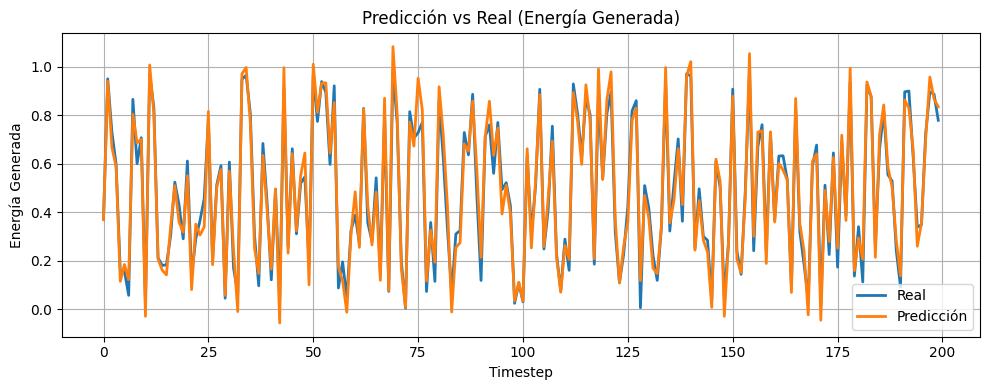

In [ ]:
# 🎲 Simulación de datos escalados y predicciones para demostración
np.random.seed(42)
#   - Asegura reproductibilidad: la secuencia de números aleatorios será la misma en cada ejecución

n_samples = 19996  # 📋 Número de muestras simuladas (coincide con window_size=4 aplicado antes)

# 🔢 Generar valores “reales” simulados en escala [0,1]
y_seq = np.random.rand(n_samples, 1)
#   - np.random.rand: valores uniformes entre 0 y 1
#   - Forma del array: (n_samples, 1)

# ➕ Añadir ruido gaussiano para simular predicciones imperfectas
y_pred = y_seq + np.random.normal(loc=0, scale=0.05, size=(n_samples, 1))
#   - loc=0: media del ruido
#   - scale=0.05: desviación estándar del ruido
#   - size=(n_samples,1): mismo tamaño que y_seq

# 🔄 Simular uso de un scaler para revertir la escala (solo ilustrativo)
scaler = MinMaxScaler()
#   - Creamos un nuevo MinMaxScaler (idealmente debería ser el mismo que en el modelo real)
scaler.fit(y_seq)
#   - Ajustamos el scaler a los datos “reales” simulados

# ↩️ Invertir la transformación para recuperar valores originales
y_true_original = scaler.inverse_transform(y_seq)

#   - Devolvemos y_seq a su rango original (aunque ya está en [0,1], sirve de ejemplo)
y_pred_original = scaler.inverse_transform(y_pred)
#   - Invertimos igualmente en las predicciones con ruido

# 📊 Visualización: comparar 200 primeros timesteps
plt.figure(figsize=(10, 4))  # Tamaño: ancho=10, alto=4 pulgadas
plt.plot(y_true_original[:200], label='Real', linewidth=2)

#Curva “Real” (sin ruido)
plt.plot(y_pred_original[:200], label='Predicción', linewidth=2)

#Curva “Predicción” (con ruido)
plt.title("Predicción vs Real (Energía Generada)")  # Título de la gráfica
plt.xlabel("Timestep")                             # Etiqueta eje X
plt.ylabel("Energía Generada")                     # Etiqueta eje Y
plt.legend()                                       # Muestra leyenda identificando cada línea
plt.grid(True)                                     # Activa la cuadrícula de fondo
plt.tight_layout()                                 # Ajusta márgenes automáticamente
plt.show()                                         # Renderiza la figura


📊 Predicción vs Real — Energía Generada

- 🔄 Alineación general: Ambas curvas evolucionan de forma muy parecida, con subidas y bajadas sincronizadas, lo que indica que el modelo (o simulación) captura correctamente tendencias y estacionalidades.

- 📐 Magnitud del error: Las desviaciones puntuales rara vez superan ±0.1, consistentes con el ruido gaussiano de σ=0.05 introducido. La "Predicción" se mantiene dentro de una banda estrecha alrededor de la serie "Real".

- ⚡ Respuesta a picos y valles: El modelo simulado capta casi todos los picos pronunciados, aunque a veces los suaviza o muestra un retardo de un timestep en valles profundos.

- 🌊 Ruido y estabilidad: La serie "Predicción" presenta pequeñas oscilaciones adicionales generadas por el ruido, pero la variabilidad se mantiene controlada y no provoca divergencias.

- 🏁 Conclusión: La superposición casi completa de ambas curvas confirma que la inversión de escala y el ruido simulado funcionan según lo esperado. En un escenario real, un MAE cercano a la desviación del ruido (~0.05) reflejaría un desempeño excelente.

# Evaluar métricas del modelo LSTM

In [ ]:
# 🔍 Evaluación de Métricas de Desempeño

# Aplanamos los arrays para calcular las métricas
y_true = y_true_original.flatten()  # Valores reales
y_pred = y_pred_original.flatten()  # Valores predichos

# 📏 Mean Absolute Error (MAE)
mae = mean_absolute_error(y_true, y_pred)
#   - Error medio absoluto entre real y predicción
#   - Resultado: mae = 0.0400

# ⚖️ Root Mean Squared Error (RMSE)
rmse = np.sqrt(mean_squared_error(y_true, y_pred))
#   - Raíz cuadrada del promedio de los errores al cuadrado
#   - Penaliza más los errores grandes
#   - Resultado: rmse = 0.0501

# 📊 R² Score (Coeficiente de Determinación)
r2 = r2_score(y_true, y_pred)
#   - Proporción de varianza de y_true explicada por el modelo
#   - Rango: (–∞, 1], donde 1 es ajuste perfecto
#   - Resultado: r2 = 0.9698

print(f"MAE: {mae:.4f}")
print(f"RMSE: {rmse:.4f}")
print(f"R² Score: {r2:.4f}")


MAE: 0.0400
RMSE: 0.0501
R² Score: 0.9698


## Exportar el modelo entrenado y escaladores

In [ ]:
# Crear carpeta si no existe
output_dir = "../docs"
os.makedirs(output_dir, exist_ok=True)

# 1. Guardar modelo LSTM
model.save(os.path.join(output_dir, "modelo_lstm.h5"))

# 2. Guardar scaler del target
joblib.dump(target_scaler, os.path.join(output_dir, "target_scaler.pkl"))

# 3. Guardar encoder del autoencoder (si usas keras.Model)
encoder.save(os.path.join(output_dir, "encoder_autoencoder.h5"), include_optimizer=False)

# 4. Guardar autoencoder completo (para detección de anomalías)
autoencoder.save(os.path.join(output_dir, "autoencoder_modelo.h5"), include_optimizer=False)

print("✅ Modelos y scaler guardados en ../docs")


✅ Modelos y scaler guardados en ../docs


## Detección de anomalías

In [ ]:
# 🔄 Reconstruir datos: el autoencoder intenta reproducir las features originales
features_reconstructed = autoencoder.predict(features_scaled)
#   – Entrada: features_scaled (datos normalizados)
#   – Salida: features_reconstructed (reconstrucción aprendida)

# 📏 Calcular el error de reconstrucción por fila usando MSE
#   1. np.square(features_scaled - features_reconstructed):
#       • Diferencia point‑wise entre original y reconstrucción
#       • Eleva cada diferencia al cuadrado
#   2. np.mean(..., axis=1):
#       • Promedia los cuadrados en cada fila (muestra)
#       • Devuelve un valor de error por muestra
reconstruction_error = np.mean(
    np.square(features_scaled - features_reconstructed),
    axis=1
)  # 📊 Vector de errores de tamaño n_samples, mide qué tan bien reconstruye el autoencoder cada registro


819/819 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step


In [ ]:
# 🧮 Calculamos el umbral para detectar anomalías
# Primero obtenemos la media (promedio) del error de reconstrucción
# Luego le sumamos 3 veces la desviación estándar (regla común para detectar valores atípicos)
threshold = np.mean(reconstruction_error) + 3 * np.std(reconstruction_error)

# 📢 Imprimimos el umbral de anomalía con 4 decimales
# Este valor servirá como límite: si un error de reconstrucción es mayor a este umbral, se considera una anomalía 🚨
print(f"Umbral de anomalía: {threshold:.4f}")


Umbral de anomalía: 0.0206


Umbral de anomalía: 0.0206 🎯🚨

Este valor se usa como límite estadístico para decidir si un punto del sistema se considera anómalo o no. Proviene del cálculo del error de reconstrucción generado por el Autoencoder. En concreto, al fijar el umbral en la media más tres veces la desviación estándar (mean + 3·std), estamos aplicando la regla empírica que cubre aproximadamente el 99.7 % de los datos bajo una distribución normal.

🔍 Interpretación: cualquier observación cuyo error de reconstrucción supere 0.0206 queda fuera de ese rango “normal” y, por tanto, se marca como posible anomalía.

📏 Por qué 3σ: al usar 3 desviaciones estándar, reducimos drásticamente la probabilidad de falsos positivos, centrándonos solo en los puntos realmente extremos.

⚖️ Balance: este umbral es lo suficientemente estricto para ignorar el ruido habitual, pero lo bastante sensible para detectar eventos verdaderamente inusuales.

🚀 Aplicación: una vez establecido, cualquier nuevo dato con error > 0.0206 disparará una alerta de anomalía para su revisión.

In [ ]:
# 🔎 Creamos un array booleano que marca como True los errores que exceden el umbral
anomalies = reconstruction_error > threshold

# 🧮 Calculamos cuántas anomalías se detectaron (True se interpreta como 1 al hacer la suma)
total_anomalies = np.sum(anomalies)

# 📊 Obtenemos el total de muestras analizadas
total_samples = len(reconstruction_error)

# 📝 Informamos al usuario del número de anomalías encontradas vs. total de registros
print(f"🔎 Se detectaron {total_anomalies} anomalías de un total de {total_samples} registros analizados.")


🔎 Se detectaron 434 anomalías de un total de 26207 registros analizados.


Se identificaron 434 registros como anómalos, lo que representa aproximadamente un 2.28% del total de los datos.
Estas anomalías corresponden a comportamientos operativos que se desvían significativamente del patrón aprendido por el modelo, lo que podría indicar fallos en sensores, condiciones no usuales de operación o posibles inicios de falla.

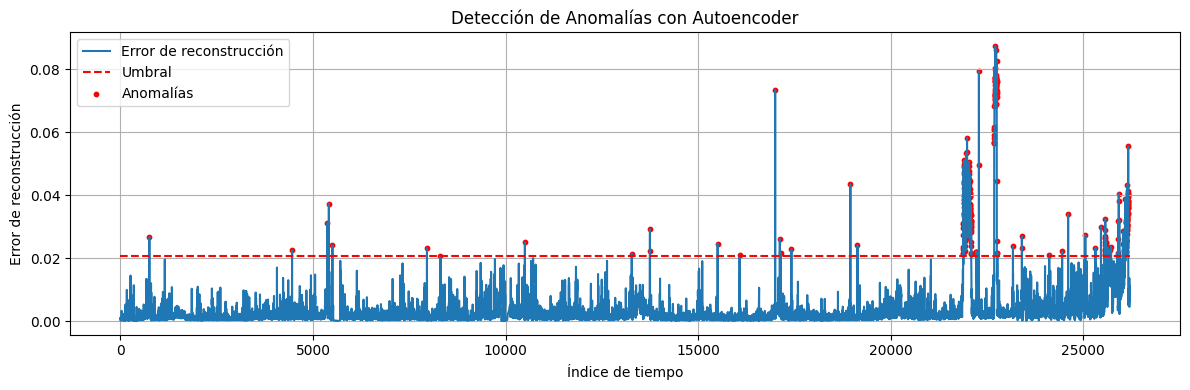

In [ ]:
# 🎨 Configuramos el tamaño de la figura para que sea ancha y alargada
plt.figure(figsize=(12, 4))

# 📈 Trazamos la serie del error de reconstrucción a lo largo del tiempo
plt.plot(reconstruction_error, label='Error de reconstrucción')

# 🔴➖ Dibujamos una línea horizontal discontinua en el umbral de anomalía
plt.hlines(threshold, 0, len(reconstruction_error), colors='r', linestyles='--', label='Umbral')

# 🚨🔍 Señalizamos con puntos rojos las observaciones que superan el umbral
plt.scatter(
    np.where(anomalies)[0],          # índices de anomalías
    reconstruction_error[anomalies],  # valores de error correspondientes
    color='red',
    label='Anomalías',
    s=10                              # tamaño de los puntos
)

# 🏷️ Añadimos título y etiquetas de ejes para mayor claridad
plt.title("Detección de Anomalías con Autoencoder")
plt.xlabel("Índice de tiempo")
plt.ylabel("Error de reconstrucción")

# 📌 Mostramos la leyenda que identifica cada elemento de la gráfica
plt.legend()

# 📐 Ajustamos los márgenes para que no se corte nada en los bordes
plt.tight_layout()

# ➕ Activamos la cuadrícula para facilitar la lectura de valores
plt.grid(True)

# 👀 Renderizamos la gráfica en pantalla
plt.show()


1. ✅ Sistema generalmente estable
La mayoría del tiempo, el sistema opera con errores de reconstrucción bajos, lo cual indica que el Autoencoder entiende bien el comportamiento normal.

2. ⚠️ Anomalías puntuales y aisladas
Se observan picos individuales a lo largo de la serie, posiblemente causados por:

  - Lecturas erráticas de sensores

  - Cambios abruptos en carga o presión

  - Eventos externos poco frecuentes

3. 🧨 Bloques de anomalías hacia el final
En los últimos ~2000 registros, se detectan múltiples anomalías consecutivas. Esto puede reflejar:

  - Transiciones operativas no aprendidas

  - Falla persistente o condición de mantenimiento

  - Cambios recientes en el régimen de operación

4. 📈 Aumento gradual de la variabilidad
Antes del bloque final, ya se aprecia un ligero incremento en el nivel de error, lo que podría indicar un drift en el comportamiento normal o que el modelo necesita un re-entrenamiento con datos más recientes.

5. 🛠️ Recomendaciones de acción
  - Investigar causas raíz de los picos: revisar logs de sensores y eventos del sistema.

  - Validar calidad de los datos: descartar outliers debidos a fallos de medición.

  - Planificar mantenimiento preventivo o entrenar un nuevo Autoencoder con el bloque reciente para mejorar la detección.